In [1]:
import numpy as np
from pathlib import Path

from pymor.basic import *
from pymor.core.pickle import load

from RBInvParam.problems.problems import build_InstationaryModelIP

set_log_levels({
    'pymor' : 'WARN'
})

set_defaults({})


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "cm",
    "font.size": 10,
    'text.latex.preamble': r'\usepackage{amsfonts} \usepackage{accents} \usepackage{mathrsfs}',
    'figure.dpi': 400
})

In [3]:
WORK_DIR = Path('/run/media/benedikt/38E84473425D444F/Dokumente/Studium/Mathematik/PhD/parabolische_inverse_probleme')
#WORK_DIR = Path('/home/benedikt/Dokumente/parabolische_inverse_probleme')
data_dir_path = WORK_DIR / Path('experiments/initial_testing_timedep')

FOM_data_path = data_dir_path / 'diffusion_FOM_300'
TR_data_path = data_dir_path / 'diffusion_TR_300'

setup_path = FOM_data_path / 'setup.pkl'
optimizer_parameter_path = FOM_data_path / 'optimizer_parameter.pkl'


with open(setup_path, 'rb') as file:
    setup = load(file)

with open(optimizer_parameter_path, 'rb') as file:
    optimizer_parameter = load(file)

if not 'FOM' in locals():
    FOM, grid_data = build_InstationaryModelIP(setup=setup)

    

data = {}

if FOM_data_path:
    with open(FOM_data_path / 'FOM_IRGNM_final.pkl', 'rb') as file:
        FOM_data = load(file)
    data['FOM'] = FOM_data

if TR_data_path:
    with open(TR_data_path / 'TR_IRGNM_final.pkl', 'rb') as file:
        TR_data = load(file)
    data['TR'] = TR_data
    


[2025-02-26 15:37:21,270][__init__] - Setting up InstationaryModelIP


Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

[2025-02-26 15:38:08,415][discretize_instationary_IP] - noise percentage is 7.0703e-08
[2025-02-26 15:38:08,416][discretize_instationary_IP] - noise_level is 1.0000e-05
[2025-02-26 15:38:08,556][__init__] - Setting up InstationaryModelIP


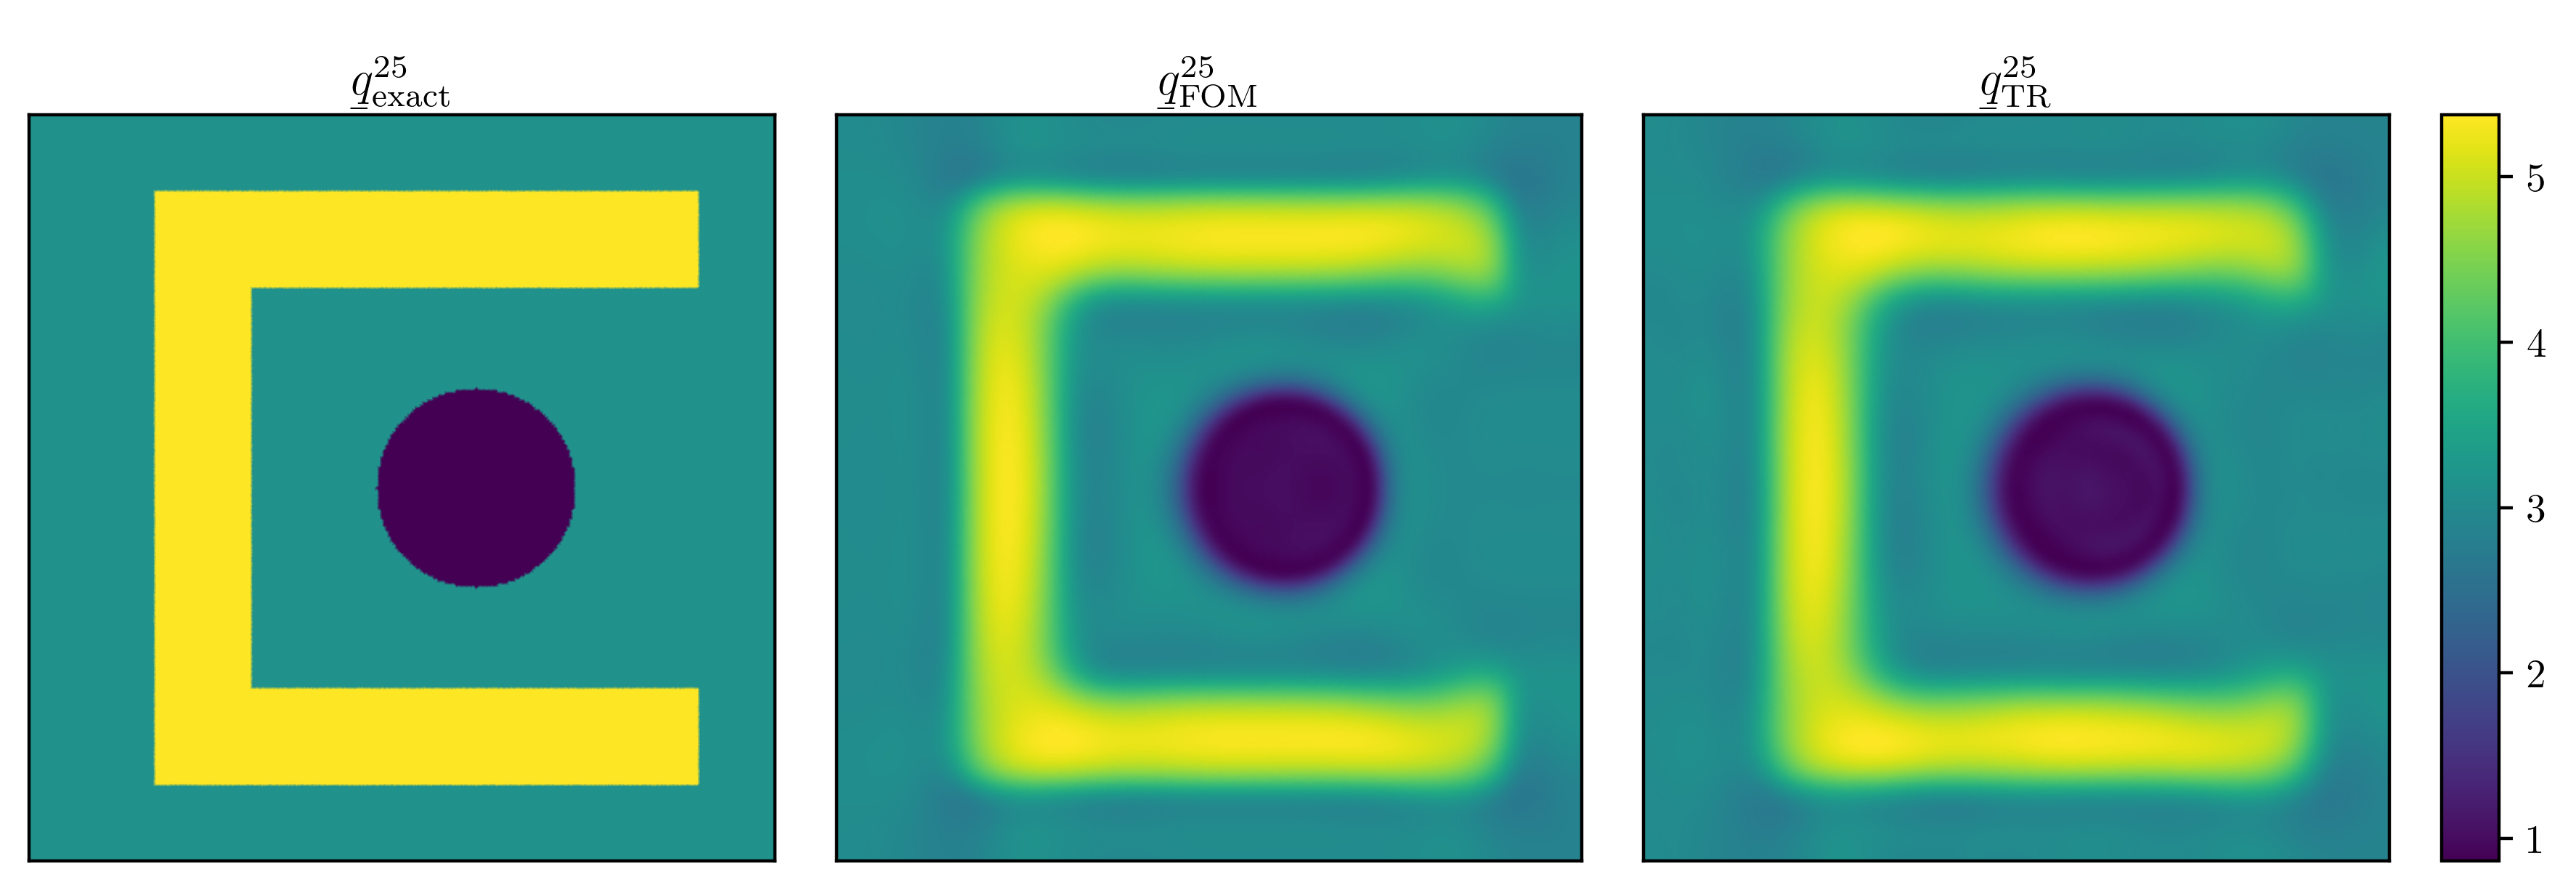

In [4]:
import matplotlib.tri as tri
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

title_pad = 12

time_step = 25
time_dep= True

if len(setup['model_parameter']['q_exact'].to_numpy()) == 1:
    assert time_step == 0
    time_dep= False
    

fig = plt.figure(figsize=(9, 3))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.075])  # Last column for colorbar

# Create subplots using gridspec
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
cax = plt.subplot(gs[3])  # Dedicated axis for colorbar

# Store subplots in a list for easy iteration
ax = [ax0, ax1, ax2]

centers = grid_data['grid'].centers(codim=2)
triang = tri.Triangulation(centers[:,0], centers[:,1])

q = setup['model_parameter']['q_exact'].to_numpy()[time_step, :]
vmin, vmax = np.min(q), np.max(q)
ax[0].tripcolor(triang, q, cmap='viridis', shading='gouraud')
if time_dep:
    ax[0].set_title(r'$\underaccent{\bar}{q}^{' + str(time_step) + r'}_\textrm{\footnotesize exact}$', pad=title_pad)
else:
    ax[0].set_title(r'$\underaccent{\bar}{q}_\textrm{\footnotesize exact}$', pad=title_pad)
    

q = data['FOM']['q'][-1].to_numpy()[time_step, :]
ax[1].tripcolor(triang, q, cmap='viridis', shading='gouraud')
if time_dep:
    ax[1].set_title(r'$\underaccent{\bar}{q}^{' + str(time_step) + r'}_\textrm{\footnotesize FOM}$', pad=title_pad)
else:
    ax[1].set_title(r'$\underaccent{\bar}{q}_\textrm{\footnotesize FOM}$', pad=title_pad)

q = data['TR']['q'][-1].to_numpy()[time_step, :]
c = ax[2].tripcolor(triang, q, cmap='viridis', shading='gouraud')
if time_dep:
    ax[2].set_title(r'$\underaccent{\bar}{q}^{' + str(time_step) + r'}_\textrm{\footnotesize  TR}$', pad=title_pad)
else:
    ax[2].set_title(r'$\underaccent{\bar}{q}_\textrm{\footnotesize TR}$', pad=title_pad)

fig.colorbar(c, cax=cax)

# Remove ticks from all subplots
for ax_ in ax:
    ax_.set_xticks([])  # Remove x-axis ticks
    ax_.set_yticks([])  # Remove y-axis ticks
    ax_.set_aspect('equal')
    ax_.set_xlim(0,1)
    ax_.set_ylim(0,1)
    
plt.tight_layout()  # Adjust spacing to prevent misalignment
#plt.show()




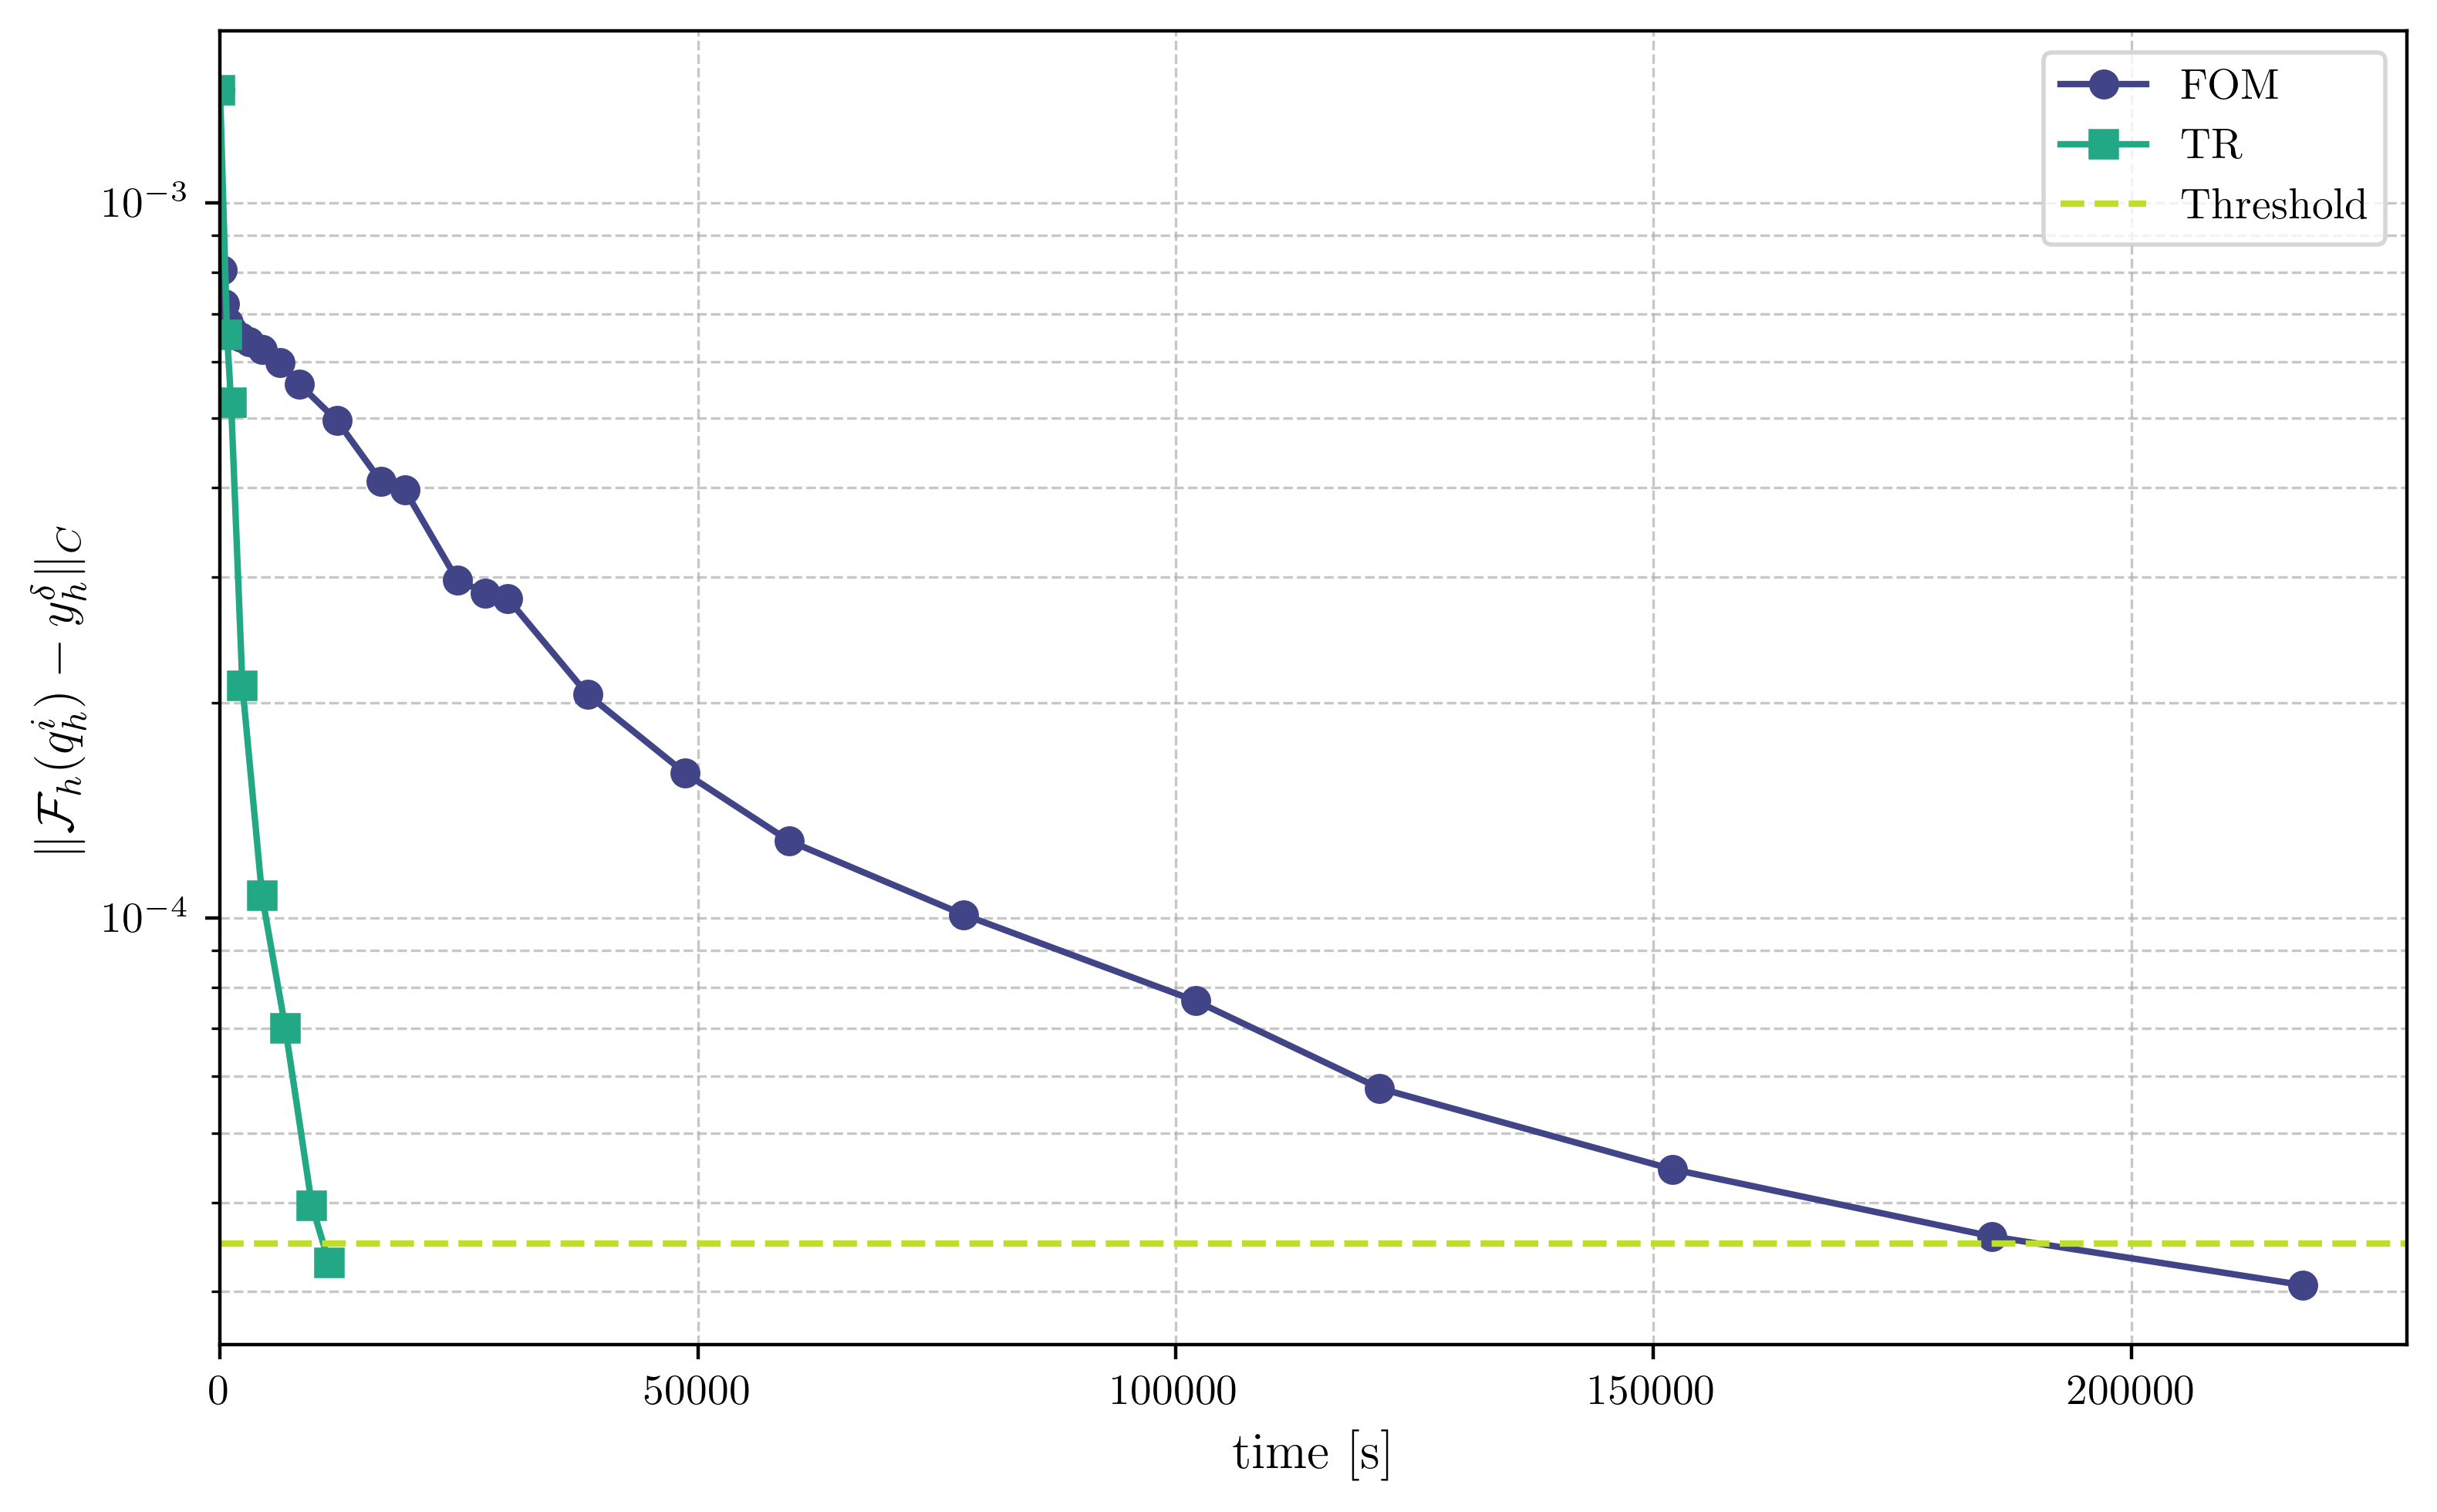

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Use the viridis colormap for consistent coloring
cmap = plt.cm.viridis
colors = [cmap(0.2), cmap(0.6), cmap(0.9)]  # Three distinct colors from viridis

fig, ax = plt.subplots(figsize=(8, 5))  # Set a good figure size

############################# FOM #############################

total_runtime = np.array([0])
total_runtime = np.append(total_runtime, data['FOM']['total_runtime'][:-1])

J = np.array(data['FOM']['J'])
J = np.sqrt(2 * J)

ax.plot(total_runtime, J, marker='o', linestyle='-', markersize=6, 
        color=colors[0], label='FOM')  # Darker viridis tone

############################# TR #############################

total_runtime = np.array([0])
total_runtime = np.append(total_runtime, data['TR']['total_runtime'][:-1])

J = np.array(data['TR']['J'])
J = np.sqrt(2 * J)

ax.plot(total_runtime, J, marker='s', linestyle='-', markersize=6, 
        color=colors[1], label='TR')  # Mid-tone viridis

############################# hline #############################

tau = optimizer_parameter['tau']
noise_level = optimizer_parameter['noise_level']
tol = optimizer_parameter['tol']
y = tau * noise_level + tol
ax.axhline(y=y, color=colors[2], linestyle='--', linewidth=1.5, label=r'Threshold')  # Light viridis tone

############################# layout #############################

ax.set_xlabel(r'time [s]', fontsize=12)
ax.set_ylabel(r'$\|\mathcal{F}_h(q_h^i)-y_h^{\delta}\|_C$', fontsize=12)
ax.set_yscale('log')

ax.set_xlim(left=0)  # Ensure x-axis starts at 0
ax.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.7)
ax.legend(loc='best', fontsize=10)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()
